In [73]:
# Includes and Standard Magic...
### Standard Magic and startup initializers.

# Load Numpy
import numpy as np
# Load MatPlotLib
import matplotlib
import matplotlib.pyplot as plt
# Load Pandas
import pandas as pd
# Load Stats
from scipy import stats
import seaborn as sns
import gurobipy as gpy
import itertools

# This lets us show plots inline and also save PDF plots if we want them
%matplotlib inline
#matplotlib.style.use('fivethirtyeight')
from matplotlib.backends.backend_pdf import PdfPages

# These two things are for Pandas, it widens the notebook and lets us display data easily.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# EF/Prop Graph building

In [74]:
# Load the data 

df_results = pd.read_csv("./PaperRun_EF-Prop.csv")
df_results.head()

,Agents,Objects,Phi,Sample,UMinEF_Solution,GRB-UMinEF-Time,UMinPO_Solution,GRB-UMinPO-Time,DP-UMinPO-Time,DP-UMinEF-Time
0,2,2,0.5,0,0,0.006910,0,0.001789,0.000838,0.000087
1,2,2,0.5,1,0,0.000778,0,0.001058,0.000584,0.000097
2,2,2,0.5,2,0,0.000916,0,0.001202,0.000663,0.000098
3,2,2,0.5,3,1,0.001342,1,0.001726,0.000920,0.000151
4,2,2,0.5,4,0,0.000855,0,0.001773,0.000696,0.000127


In [75]:
df_results.groupby(["Agents", "Objects", "Phi"]).mean()

Sample  UMinEF_Solution  GRB-UMinEF-Time  \
Agents Objects Phi                                              
2      2       0.50    24.5             0.40         0.000989   
               0.75    24.5             0.54         0.000767   
               1.00    24.5             0.32         0.000738   
3      3       0.50    24.5             0.10         0.001189   
               0.75    24.5             0.20         0.001402   
               1.00    24.5             0.18         0.001296   
4      4       0.50    24.5             0.02         0.002375   
               0.75    24.5             0.08         0.002394   
               1.00    24.5             0.12         0.002261   
5      5       0.50    24.5             0.00         0.003259   
               0.75    24.5             0.04         0.003170   
               1.00    24.5             0.00         0.003115   
6      6       0.50    24.5             0.00         0.011353   
               0.75    24.5             0.00         0.011908   
               1.00    24.5             0.02         0.012996   
7      7       0.50    24.5             0.00         0.018933   
               0.75    24.5             0.00         0.020612   
               1.00    24.5             0.02         0.020219   

                     UMinPO_Solution  GRB-UMinPO-Time  DP-UMinPO-Time  \
Agents Objects Phi                                                      
2      2       0.50             0.40         0.001196        0.000616   
               0.75             0.54         0.001023        0.000544   
               1.00             0.32         0.001048        0.000561   
3      3       0.50             0.84         0.001493        0.000717   
               0.75             0.86         0.001767        0.000880   
               1.00             0.94         0.001631        0.000788   
4      4       0.50             0.44         0.002199        0.002363   
               0.75             0.68         0.002213        0.002491   
               1.00             0.70         0.002128        0.002444   
5      5       0.50             0.72         0.003184        0.025551   
               0.75             0.92         0.003031        0.028581   
               1.00             0.96         0.003035        0.028442   
6      6       0.50             0.36         0.005173        0.400946   
               0.75             0.78         0.005415        0.485578   
               1.00             0.94         0.005479        0.480919   
7      7       0.50             0.48         0.006175        7.001269   
               0.75             0.96         0.006088        8.191954   
               1.00             1.00         0.006143        8.853636   

                     DP-UMinEF-Time  
Agents Objects Phi                   
2      2       0.50        0.000093  
               0.75        0.000086  
               1.00        0.000081  
3      3       0.50        0.000267  
               0.75        0.000326  
               1.00        0.000310  
4      4       0.50        0.002744  
               0.75        0.002825  
               1.00        0.002705  
5      5       0.50        0.042502  
               0.75        0.041822  
               1.00        0.043348  
6      6       0.50        0.951200  
               0.75        0.998317  
               1.00        0.989640  
7      7       0.50       20.251641  
               0.75       20.216852  
               1.00       20.323344

In [76]:
df_results = df_results.melt(id_vars=["Agents", "Objects", "Phi"],
                value_vars=["GRB-UMinEF-Time", "GRB-UMinPO-Time", "DP-UMinPO-Time", "DP-UMinEF-Time"], 
                var_name="Algorithm",
                value_name="Runtime")
df_results

,Agents,Objects,Phi,Algorithm,Runtime
0,2,2,0.5,GRB-UMinEF-Time,0.006910
1,2,2,0.5,GRB-UMinEF-Time,0.000778
2,2,2,0.5,GRB-UMinEF-Time,0.000916
3,2,2,0.5,GRB-UMinEF-Time,0.001342
4,2,2,0.5,GRB-UMinEF-Time,0.000855
...,...,...,...,...,...
3595,7,7,1.0,DP-UMinEF-Time,20.427151
3596,7,7,1.0,DP-UMinEF-Time,20.333276
3597,7,7,1.0,DP-UMinEF-Time,20.305742
3598,7,7,1.0,DP-UMinEF-Time,20.276880


<Figure size 1080x576 with 0 Axes>

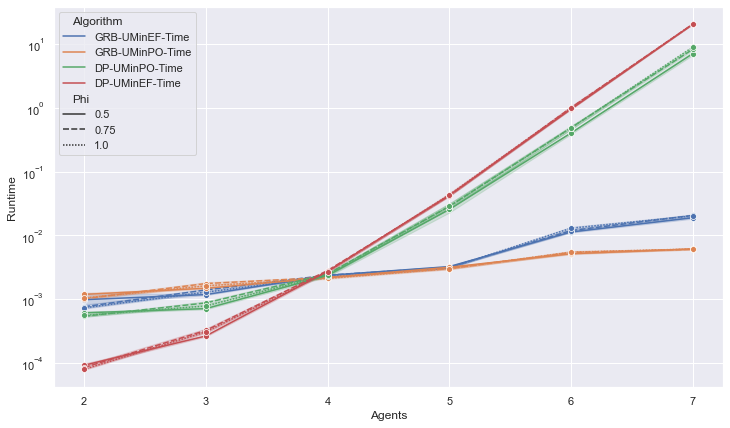

In [77]:
plt.figure(figsize = (15,8))
sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(ax=ax, data=df_results, x="Agents", y="Runtime", hue="Algorithm", style="Phi", marker="o")
ax.set(yscale="log")
plt.savefig("EF-PO.pdf", bbox_inches='tight')

# EF1/PROP1 Graph Building

In [78]:
# Load the data 

df_results = pd.read_csv("./PaperRun_EF1-Prop1.csv")
df_results.head()

,Agents,Objects,Phi,Sample,UMinEF1_Solution,GRB-UMinEF1-Time,UMinPO1_Solution,GRB-UMinPO1-Time,DP-UMinPO1-Time,DP-UMinEF1-Time
0,2,2,0.5,0,0,0.009090,1,0.006374,0.001238,0.000171
1,2,2,0.5,1,0,0.001592,1,0.003421,0.000792,0.000146
2,2,2,0.5,2,0,0.002667,1,0.002878,0.000752,0.000138
3,2,2,0.5,3,1,0.001513,1,0.002193,0.000724,0.000144
4,2,2,0.5,4,0,0.001424,1,0.002556,0.000820,0.000244


In [79]:
df_results.groupby(["Agents", "Objects", "Phi"]).mean()

Sample  UMinEF1_Solution  GRB-UMinEF1-Time  \
Agents Objects Phi                                                
2      2       0.50    24.5              0.40          0.001640   
               0.75    24.5              0.54          0.001264   
               1.00    24.5              0.32          0.001126   
3      3       0.50    24.5              0.36          0.003478   
               0.75    24.5              0.52          0.003606   
               1.00    24.5              0.54          0.003519   
4      4       0.50    24.5              0.22          0.010759   
               0.75    24.5              0.50          0.010021   
               1.00    24.5              0.54          0.009595   
5      5       0.50    24.5              0.20          0.022613   
               0.75    24.5              0.46          0.021416   
               1.00    24.5              0.48          0.021218   
6      6       0.50    24.5              0.08          0.057527   
               0.75    24.5              0.30          0.058523   
               1.00    24.5              0.46          0.055776   
7      7       0.50    24.5              0.04          0.127582   
               0.75    24.5              0.20          0.143436   
               1.00    24.5              0.42          0.110221   

                     UMinPO1_Solution  GRB-UMinPO1-Time  DP-UMinPO1-Time  \
Agents Objects Phi                                                         
2      2       0.50               1.0          0.002342         0.000759   
               0.75               1.0          0.001988         0.000631   
               1.00               1.0          0.001733         0.000568   
3      3       0.50               1.0          0.003665         0.001000   
               0.75               1.0          0.003671         0.001029   
               1.00               1.0          0.003615         0.000999   
4      4       0.50               1.0          0.005187         0.003790   
               0.75               1.0          0.005495         0.004229   
               1.00               1.0          0.005293         0.004036   
5      5       0.50               1.0          0.007033         0.043355   
               0.75               1.0          0.007325         0.050316   
               1.00               1.0          0.007259         0.052241   
6      6       0.50               1.0          0.008852         0.717027   
               0.75               1.0          0.008592         0.751172   
               1.00               1.0          0.008651         0.766102   
7      7       0.50               1.0          0.009838        11.944899   
               0.75               1.0          0.010222        13.829797   
               1.00               1.0          0.010614        15.652687   

                     DP-UMinEF1-Time  
Agents Objects Phi                    
2      2       0.50         0.000143  
               0.75         0.000128  
               1.00         0.000108  
3      3       0.50         0.000556  
               0.75         0.000564  
               1.00         0.000565  
4      4       0.50         0.005439  
               0.75         0.006727  
               1.00         0.005644  
5      5       0.50         0.088927  
               0.75         0.094614  
               1.00         0.092574  
6      6       0.50         1.754823  
               0.75         1.742687  
               1.00         1.751548  
7      7       0.50        37.508651  
               0.75        37.724294  
               1.00        37.966253

In [80]:
df_results = df_results.melt(id_vars=["Agents", "Objects", "Phi"],
                value_vars=["GRB-UMinEF1-Time", "GRB-UMinPO1-Time", "DP-UMinPO1-Time", "DP-UMinEF1-Time"], 
                var_name="Algorithm",
                value_name="Runtime")
df_results

,Agents,Objects,Phi,Algorithm,Runtime
0,2,2,0.5,GRB-UMinEF1-Time,0.009090
1,2,2,0.5,GRB-UMinEF1-Time,0.001592
2,2,2,0.5,GRB-UMinEF1-Time,0.002667
3,2,2,0.5,GRB-UMinEF1-Time,0.001513
4,2,2,0.5,GRB-UMinEF1-Time,0.001424
...,...,...,...,...,...
3595,7,7,1.0,DP-UMinEF1-Time,37.747715
3596,7,7,1.0,DP-UMinEF1-Time,37.981411
3597,7,7,1.0,DP-UMinEF1-Time,37.475706
3598,7,7,1.0,DP-UMinEF1-Time,37.883848


<Figure size 1080x576 with 0 Axes>

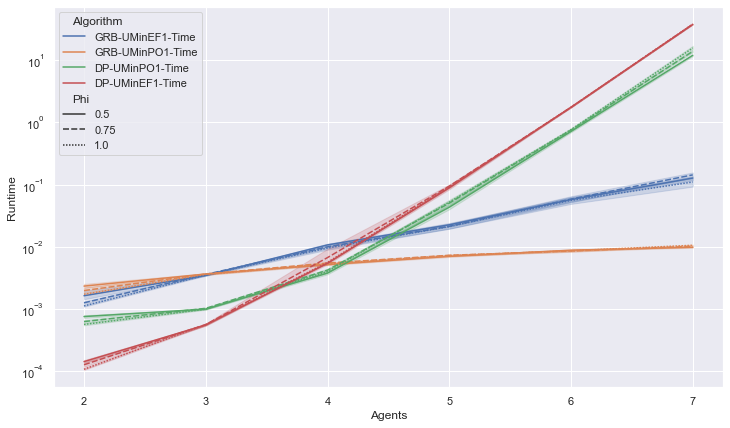

In [82]:
plt.figure(figsize = (15,8))
sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(ax=ax, data=df_results, x="Agents", y="Runtime", hue="Algorithm", style="Phi")
ax.set(yscale="log")
plt.savefig("EF1-PO1.pdf", bbox_inches='tight')